# Optimize your hset

IRASA - as an algoritm - is very appealing, because its so simple. In the end we are just up/downsampling signals, computing psd's and averaging them.
This means that we only have a single hyperparameter to set when running a model, the set of up- and downsampling factors. 
Correctly specifying the hset is very important to avoid poorly specified models (see also irasa_pitfalls.ipynb and improving_irasa_models.ipynb).
In both examples we looked at rather simple spectra, where power decreases with the same exponent across the whole spectrum.
Here we consider also spectra that contain a spectral knee and introduce an approach to improve your hset specification. In the presence of spectral knees.

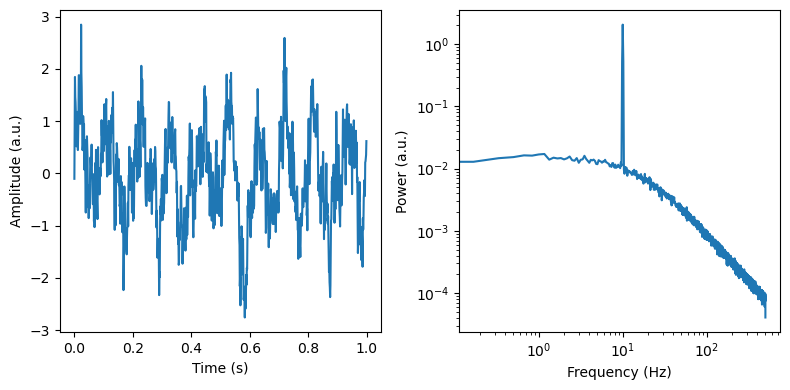

In [1]:
from neurodsp.sim import sim_combined
from neurodsp.utils import create_times
import numpy as np
import scipy.signal as dsp
import matplotlib.pyplot as plt
import pandas as pd
from pyrasa.irasa import irasa

# %% Lets check the knee
fs = 1000
n_seconds = 60
knee_freq = 15
exp = 1.5
knee = knee_freq ** exp
duration=6
overlap=0.5

sim_components = {'sim_knee': {'exponent1' : -.0, 'exponent2': -1*exp, 'knee': knee}, 
                  'sim_oscillation': {'freq' : 10}}

sig = sim_combined(n_seconds=n_seconds, fs=fs, components=sim_components)
times = create_times(n_seconds=n_seconds, fs=fs)


max_times = times < 1
f, axes = plt.subplots(ncols=2, figsize=(8, 4))
axes[0].plot(times[max_times], sig[max_times])
axes[0].set_ylabel('Amplitude (a.u.)')
axes[0].set_xlabel('Time (s)')
freq, psd = dsp.welch(sig, fs=fs, nperseg=duration*fs, noverlap=duration*fs*overlap)
axes[1].loglog(freq, psd)
axes[1].set_ylabel('Power (a.u.)')
axes[1].set_xlabel('Frequency (Hz)')

plt.tight_layout()

When things are specified correctly we can rather unproblematically regenerate our simulated aperiodic model parameters.

,Offset,Knee,Exponent_1,Exponent_2,fit_type,Knee Frequency (Hz),tau,ch_name
0,3.532808e-08,65.07895,0.014112,1.512481,knee,15.032112,0.010588,0


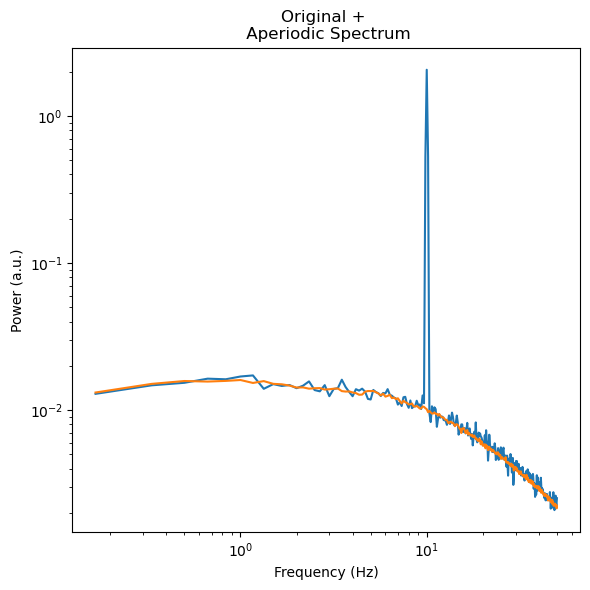

In [2]:
irasa_out = irasa(sig, 
                    fs=fs, 
                    band=(.1, 50), 
                    psd_kwargs={'nperseg': duration*fs, 
                                'noverlap': duration*fs*overlap
                            },
                    hset_info=(1, 2., 0.05))

f, ax = plt.subplots(figsize=(6,6))
ax.loglog(irasa_out.freqs, irasa_out.raw_spectrum[0,:], label='psd')
ax.loglog(irasa_out.freqs, irasa_out.aperiodic[0,:])
ax.set_ylabel('Power (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Original + \n Aperiodic Spectrum')

f.tight_layout()

irasa_out.fit_aperiodic_model(fit_func='knee').aperiodic_params

However, sometimes we might feel the need to drastically increase our hmax, because we have a very broad oscillation that we want 
to remove from our signal. In this case we start running into problems when trying to recover our simulated Knee Frequency.
This comes from the matter that the exponent before and after the knee get mixed up ind up-/downsampling.

,Offset,Knee,Exponent_1,Exponent_2,fit_type,Knee Frequency (Hz),tau,ch_name
0,7.486770e-10,64.668732,0.27764,1.2669,knee,9.85591,0.016148,0


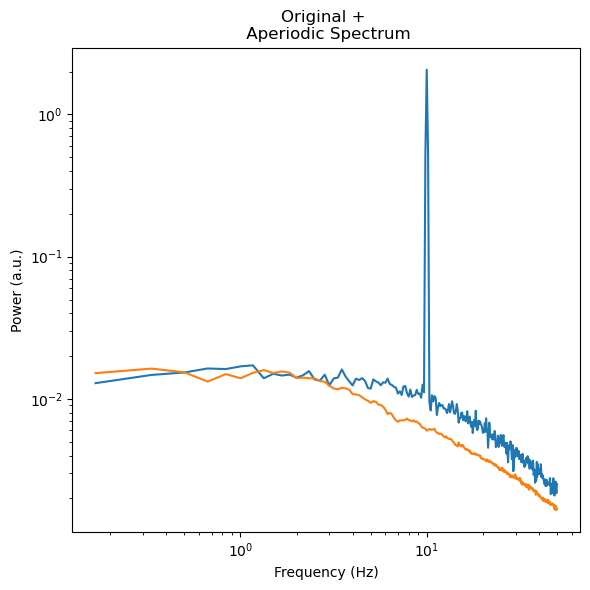

In [3]:
irasa_out_bad = irasa(sig, 
                    fs=fs, 
                    band=(.1, 50), 
                    psd_kwargs={'nperseg': duration*fs, 
                                'noverlap': duration*fs*overlap
                            },
                    hset_info=(1, 8, 0.05))


f, ax = plt.subplots(figsize=(6,6))
ax.loglog(irasa_out_bad.freqs, irasa_out_bad.raw_spectrum[0,:], label='psd')
ax.loglog(irasa_out_bad.freqs, irasa_out_bad.aperiodic[0,:])
ax.set_ylabel('Power (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Original + \n Aperiodic Spectrum')

f.tight_layout()

irasa_out_bad.fit_aperiodic_model(fit_func='knee').aperiodic_params

So how do we set the hset to avoid this issue. Here I am introducing a way to optimize the hset. 
For this we can take the absolute periodic spectrum, which contains apart from the oscillations also in a way the model error, as we get the periodic spectrum by subtracting the "aperiodic spectrum" from the original psd.
However, to get rid from the oscillations in the "periodic spectrum" we need to apply a filter. In Pyrasa we use median filters with an appropriate kernel size (Note: the kernel should go beyond the width of the oscillations in the signal).
Now computing the area under the curve for the residual spectrum generates a "filtered" broadband error estimation that can be used reduce the overall error between the original spectrum (blue line) and modeled aperiodic spectrum (orange line).
Below we can see that the good model has a much lower "error" than the bad model.

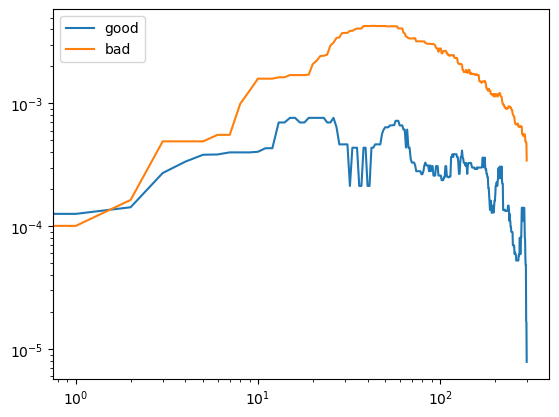

In [4]:
from scipy.signal import medfilt

abs_periodic_good = medfilt(np.abs(irasa_out.periodic[0,:]),  kernel_size=21)
abs_periodic_bad = medfilt(np.abs(irasa_out_bad.periodic[0,:]),  kernel_size=21)


plt.loglog(abs_periodic_good, label='good')
plt.loglog(abs_periodic_bad, label='bad')
plt.legend()

In [5]:
np.trapz(abs_periodic_bad) > np.trapz(abs_periodic_good)

True

However, you don't need to calculate it by hand. The IrasaSpectrum object that gets returned by irasa has a method called `get_aperiodic_error`. 
That is taking your model specifications to compute the error of your aperiodic spectrum. You just need to specify your kernel size and are good to go :)

In [6]:
irasa_out_bad.get_aperiodic_error(kernel_size=21)

,error,ch_name,hmax,lower_band,upper_band,frequency_resolution
0,0.5703,0,8,0.1,50,0.166667


In [7]:
irasa_out.get_aperiodic_error(kernel_size=21)

,error,ch_name,hmax,lower_band,upper_band,frequency_resolution
0,0.086178,0,2.0,0.1,50,0.166667
